# 🔹UFC Fight Predictor Feature Engineering

<div style="text-align: center;">
  🔹 <img src="../img/ufc_logo.png" width="50" /> 🔹
</div>

## 1. Import Libraries and Setup Environment

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get the current working directory
current_dir = os.getcwd()

# Navigate to the project root
project_root = os.path.abspath(os.path.join(current_dir, '..'))

# Import from /src
sys.path.append(os.path.join(project_root, 'src'))
from utils.helpers import *
from utils.io_model import *
from utils.ufc_data import UFCData

<div style="text-align: center;">
  🔹 <img src="../img/ufc_logo.png" width="50" /> 🔹
</div>

## 2. Load Data

In [2]:
# Define the path to the CSV file
file_path = os.path.join(project_root, 'data', 'processed', 'ufc_etl.csv')

# Load the CSV into a DataFrame
try:
    ufc_df = pd.read_csv(file_path)
    print_header(f"Data loaded succesfully", color='bright_green')
except Exception as e:
    print_header(f"Error loading data: {e}", color='bright_red')

╔═══════════════════════════╗
║  Data loaded succesfully  ║
╚═══════════════════════════╝


<div style="text-align: center;">
  🔹 <img src="../img/ufc_logo.png" width="50" /> 🔹
</div>

## 3. Feature Engineering

#### Create the target value: **0** (Fighter Red wins) or **1** (Fighter Blue wins)

In [3]:
ufc_df['label'] = ufc_df['Winner'].apply(lambda x: 1 if x == 'Blue' else 0)
ufc_df=ufc_df.drop('Winner', axis=1)

## 4. Initialize UFCData object

In [4]:
ufc_data = UFCData(ufc_df)
ufc_data.summary()

🧪Samples: 6541
🧪Train/Test split: 5232/1309
🧪Features: 68
🧪Categorical: 5, Numerical: 63


### Categorical Data

### Stance
- **Orthodox Stance:** A fighter in orthodox stance leads with their left foot and left hand, making it the natural stance for right-handed individuals. 
- **Southpaw Stance:** A fighter in southpaw stance leads with their right foot and right hand, making it the natural stance for left-handed individuals. 
- **Open Stance Matchup:** When one fighter is orthodox and the other is southpaw, it creates an "open stance" matchup. This differs from a "closed stance" where both fighters are in the same stance (e.g., both orthodox or both southpaw)
- **Switch:** When a fighter switches from an orthodox to a southpaw stance or vice versa, it can disrupt their opponent's rhythm, causing them to miss or react incorrectly to strikes. 

### Feature Construction

In [5]:
# Finish Rate (Red & Blue):
RedFinishRate = (ufc_df['RedWinsByKO'] + ufc_df['RedWinsBySubmission'] + ufc_df['RedWinsByTKODoctorStoppage']) / ufc_df['RedWins'].replace(0, 1)
BlueFinishRate = (ufc_df['BlueWinsByKO'] + ufc_df['BlueWinsBySubmission'] + ufc_df['BlueWinsByTKODoctorStoppage']) / ufc_df['BlueWins'].replace(0, 1)
ufc_df['FinishRate'] = BlueFinishRate - RedFinishRate

In [6]:
#Win Ratio (Red & Blue)
RedWinRatio = ufc_df['RedWins'] / (ufc_df['RedWins'] + ufc_df['RedLosses']).replace(0, 1)
BlueWinRatio = ufc_df['BlueWins'] / (ufc_df['BlueWins'] + ufc_df['BlueLosses']).replace(0, 1)
ufc_df['WinRatio']= BlueWinRatio - RedWinRatio 

In [7]:
# Experience per Age
RedExpPerAge = ufc_df['RedTotalRoundsFought'] / ufc_df['RedAge']
BlueExpPerAge = ufc_df['BlueTotalRoundsFought'] / ufc_df['BlueAge']
ufc_df['ExpPerAge'] = RedExpPerAge - BlueExpPerAge

In [8]:
# Reach Advantage Ratio
ufc_df['ReachAdvantageRatio'] = ufc_df['RedReachCms'] / ufc_df['BlueReachCms']

In [9]:
# Height/Reach Ratio
RedHeightReachRatio = ufc_df['RedHeightCms'] / ufc_df['RedReachCms']
BlueHeightReachRatio = ufc_df['BlueHeightCms'] / ufc_df['BlueReachCms']
ufc_df['HeightReachRatio']= BlueHeightReachRatio - RedHeightReachRatio

In [10]:
# Win By Decision
BlueWinsByDecision = ufc_df[['BlueWinsByDecisionMajority', 'BlueWinsByDecisionSplit', 'BlueWinsByDecisionUnanimous']].sum(axis=1)
RedWinsByDecision = ufc_df[['RedWinsByDecisionMajority', 'RedWinsByDecisionSplit', 'RedWinsByDecisionUnanimous']].sum(axis=1)
ufc_df['WinsByDecision']=BlueWinsByDecision- RedWinsByDecision

In [11]:
# Decision Rate
BlueDecisionRate = BlueWinsByDecision / ufc_df['BlueWins'].replace(0, 1)  # Evitar división por cero
RedDecisionRate = RedWinsByDecision  / ufc_df['RedWins'].replace(0, 1)  # Evitar división por cero
ufc_df['DecisionRate']= BlueDecisionRate - RedDecisionRate

## 4. Update UFCData object

In [12]:
ufc_data = UFCData(ufc_df)
ufc_data.summary()

🧪Samples: 6541
🧪Train/Test split: 5232/1309
🧪Features: 75
🧪Categorical: 5, Numerical: 70


## 5. Check Correlation Matrix

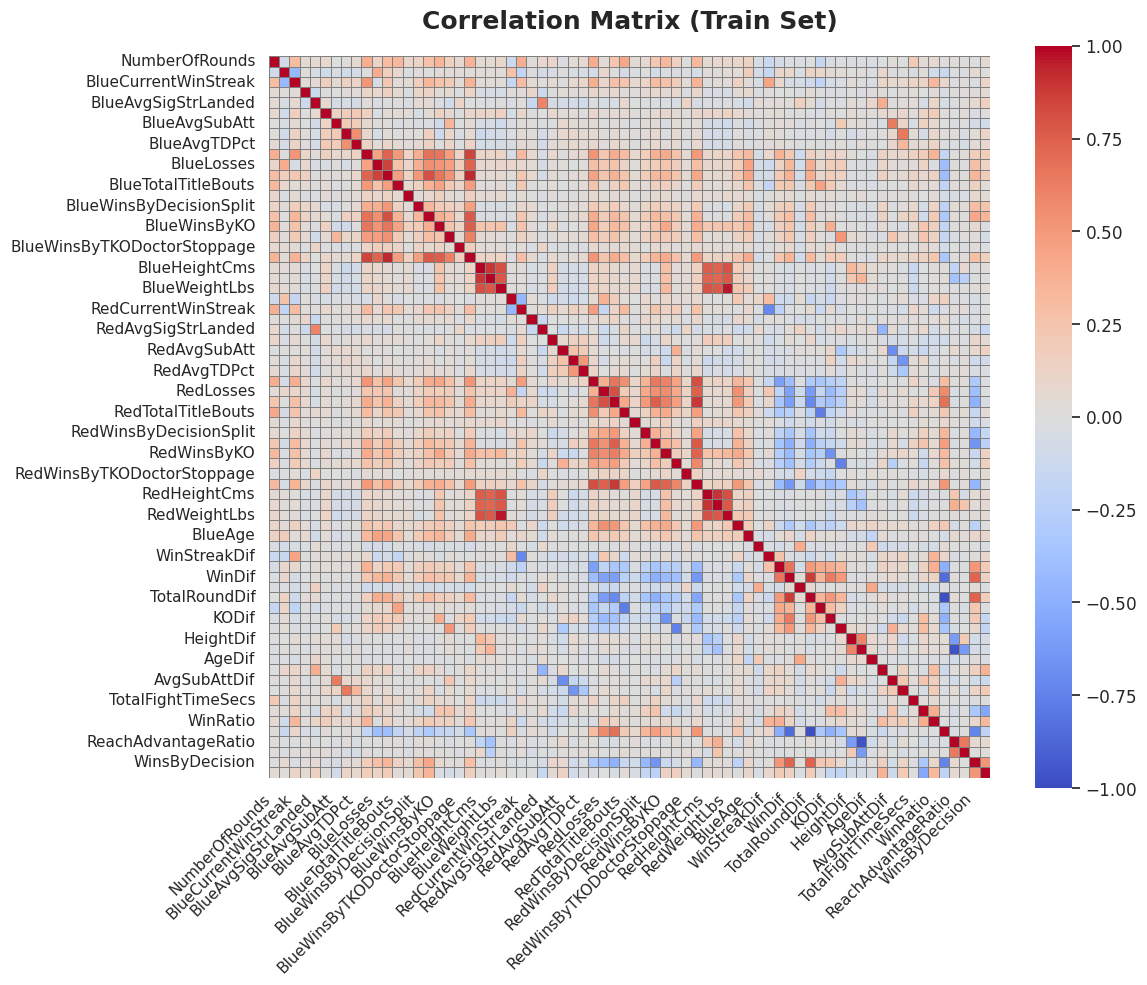

In [13]:
status = False
ufc_data.compute_corr(processed = status)
ufc_data.top_corr(processed = status)
ufc_data.plot_corr(processed = status)

### Feature Selection

Dado lo siguiente:
-  LoseStreakDif: BlueCurrentLoseStreak - RedCurrentLoseStreak
-  WinStreakDif: BlueCurrentWinStreak - RedCurrentWinStreak
-  LongestWinStreakDif: BlueLongestWinStreak - 'RedLongestWinStreak
-  WinDif: BlueWins - RedWins
-  LossDif: BlueLosses - RedLosses
-  TotalRoundDif: BlueTotalRoundsFought - RedTotalRoundsFought
-  TotalTitleBoutDif: BlueTotalTitleBouts - RedTotalTitleBouts
-  KODif: BlueWinsByKO - RedWinsByKO
-  SubDif: BlueWinsBySubmission - RedWinsBySubmission
-  HeightDif: BlueHeightCms - RedHeightCms
-  ReachDif: BlueReachCms - RedReachCms
-  AgeDif: BlueAge - RedAge
  
Se eliminan ciertas columnas que pueden ser redundantes.

In [14]:
ufc_df=ufc_df.drop(['BlueCurrentLoseStreak', 'RedCurrentLoseStreak','BlueCurrentWinStreak',
                      'RedCurrentWinStreak','BlueLongestWinStreak', 'RedLongestWinStreak', 'BlueWins',
                      'RedWins','BlueLosses','RedLosses', 'BlueTotalRoundsFought','RedTotalRoundsFought',
                      'BlueTotalTitleBouts', 'RedTotalTitleBouts', 'BlueWinsByKO', 'RedWinsByKO', 'BlueWinsBySubmission',
                      'RedWinsBySubmission','BlueHeightCms','RedHeightCms','BlueReachCms','RedReachCms',
                      'BlueAge', 'RedAge'], axis=1)

También aquellas relacionadas con los features construidos:
- WinsByDecision
- DecisionRate
- FinishRate


In [15]:
ufc_df=ufc_df.drop(['BlueWinsByDecisionSplit', 'BlueWinsByDecisionUnanimous',
       'BlueWinsByTKODoctorStoppage', 'RedWinsByDecisionMajority',
       'RedWinsByDecisionSplit', 'RedWinsByDecisionUnanimous',
       'RedWinsByTKODoctorStoppage','BlueWinsByDecisionMajority'], axis=1)

### Low Variance columns
- BlueDraws
- RedDraws
- BlueWeightLbs
- RedWeightLbs
- TitleBout_True 

In [16]:
ufc_df = ufc_df.drop(['BlueDraws','RedDraws','BlueWeightLbs','RedWeightLbs'], axis=1)

In [17]:
# Preview the first few records
display(ufc_df.head())
display(ufc_df.columns)

,TitleBout,Gender,NumberOfRounds,BlueAvgSigStrLanded,BlueAvgSigStrPct,BlueAvgSubAtt,BlueAvgTDLanded,BlueAvgTDPct,BlueStance,RedAvgSigStrLanded,...,BetterRank,TotalFightTimeSecs,label,FinishRate,WinRatio,ExpPerAge,ReachAdvantageRatio,HeightReachRatio,WinsByDecision,DecisionRate
0,False,MALE,5,4.13,0.36,0.0,1.96,0.46,Southpaw,3.88,...,Red,882.0,1,0.283333,-0.035714,0.477778,0.947368,-0.065058,-4,-0.283333
1,False,MALE,3,7.36,0.56,1.1,1.24,0.23,Orthodox,4.67,...,neither,696.0,0,0.293233,0.042614,1.222222,1.000000,0.028571,-9,-0.293233
2,False,MALE,3,3.32,0.48,0.2,2.26,0.28,Orthodox,4.44,...,Red,717.0,0,0.500000,0.095238,0.077799,1.046154,0.028733,-2,-0.500000
3,False,MALE,3,5.50,0.47,0.0,0.36,0.25,Orthodox,2.82,...,neither,824.0,1,-0.100000,-0.261905,-0.453704,1.013158,0.025803,2,0.100000
4,False,MALE,3,5.94,0.52,0.0,0.25,0.50,Orthodox,6.51,...,neither,900.0,1,-0.607143,0.222222,0.064516,1.014493,0.013872,2,0.607143


Index(['TitleBout', 'Gender', 'NumberOfRounds', 'BlueAvgSigStrLanded',
       'BlueAvgSigStrPct', 'BlueAvgSubAtt', 'BlueAvgTDLanded', 'BlueAvgTDPct',
       'BlueStance', 'RedAvgSigStrLanded', 'RedAvgSigStrPct', 'RedAvgSubAtt',
       'RedAvgTDLanded', 'RedAvgTDPct', 'RedStance', 'LoseStreakDif',
       'WinStreakDif', 'LongestWinStreakDif', 'WinDif', 'LossDif',
       'TotalRoundDif', 'TotalTitleBoutDif', 'KODif', 'SubDif', 'HeightDif',
       'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif', 'AvgTDDif',
       'BetterRank', 'TotalFightTimeSecs', 'label', 'FinishRate', 'WinRatio',
       'ExpPerAge', 'ReachAdvantageRatio', 'HeightReachRatio',
       'WinsByDecision', 'DecisionRate'],
      dtype='object')

## 4. Update UFCData object

In [18]:
ufc_data = UFCData(ufc_df)
ufc_data.summary()

🧪Samples: 6541
🧪Train/Test split: 5232/1309
🧪Features: 39
🧪Categorical: 5, Numerical: 34


## 5. Check Correlation Matrix

In [19]:
status = False
ufc_data.compute_corr(processed = status)
ufc_data.top_corr(processed = status)

,Feature 1,Feature 2,Correlation
420,TotalRoundDif,ExpPerAge,0.980629
491,ReachDif,ReachAdvantageRatio,0.965241
372,WinDif,TotalRoundDif,0.868544
385,WinDif,ExpPerAge,0.849347
423,TotalRoundDif,WinsByDecision,0.741877
553,ExpPerAge,WinsByDecision,0.737463
388,WinDif,WinsByDecision,0.732486
251,RedAvgSubAtt,AvgSubAttDif,0.694582
351,LongestWinStreakDif,WinDif,0.660869
276,RedAvgTDLanded,AvgTDDif,0.655455


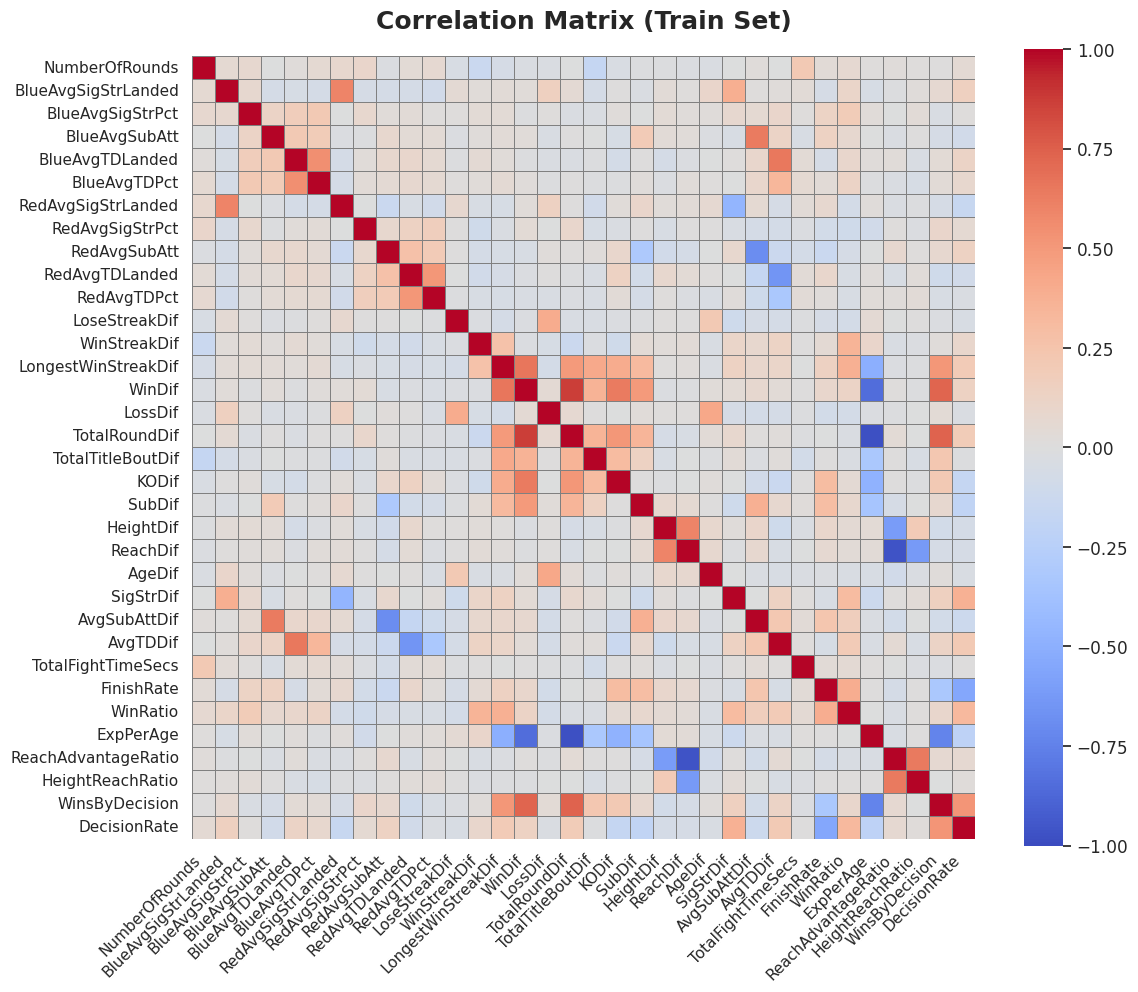

In [20]:
ufc_data.plot_corr(processed = status)

<div style="text-align: center;">
  🔹 <img src="../img/ufc_logo.png" width="50" /> 🔹
</div>

## 6. Inicialize Modeling Data: Standarize Numerical Data & Encode Categorical Data

In [21]:
ufc_data.standardize()
ufc_data.encode()

## 7. Check Modeling Correlation Matrix

In [22]:
status = True
ufc_data.compute_corr(processed = status)
ufc_data.top_corr(processed = status)

,Feature 1,Feature 2,Correlation
894,TotalRoundDif,ExpPerAge,0.980629
405,BetterRank_Red,BetterRank_neither,0.967431
965,ReachDif,ReachAdvantageRatio,0.965241
846,WinDif,TotalRoundDif,0.868544
859,WinDif,ExpPerAge,0.849347
255,RedStance_Orthodox,RedStance_Southpaw,0.846054
89,BlueStance_Orthodox,BlueStance_Southpaw,0.840822
897,TotalRoundDif,WinsByDecision,0.741877
1027,ExpPerAge,WinsByDecision,0.737463
862,WinDif,WinsByDecision,0.732486


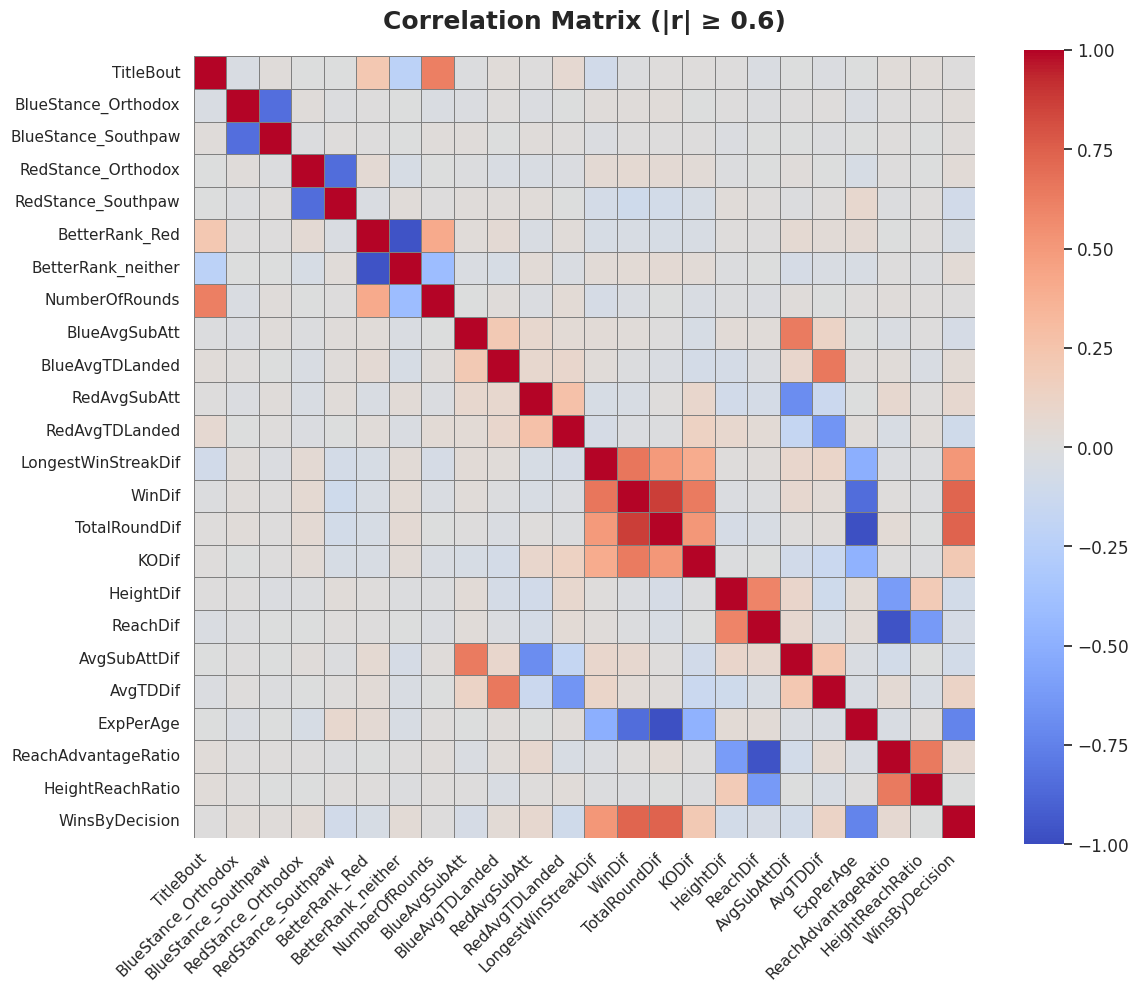

In [23]:
ufc_data.plot_corr(processed = status, threshold = 0.6)

## 6. Check Modeling Data

In [24]:
ufc_data._X_train_processed

,TitleBout,Gender_MALE,BlueStance_Orthodox,BlueStance_Southpaw,BlueStance_Switch,RedStance_Open Stance,RedStance_Orthodox,RedStance_Southpaw,RedStance_Switch,BetterRank_Blue,...,AvgSubAttDif,AvgTDDif,TotalFightTimeSecs,FinishRate,WinRatio,ExpPerAge,ReachAdvantageRatio,HeightReachRatio,WinsByDecision,DecisionRate
5014,0,1,0,1,0,0,0,1,0,0,...,-1.025880,0.102213,0.708351,0.161448,0.275168,-0.164815,-0.035200,0.369952,0.268586,0.133795
3094,0,1,0,1,0,0,1,0,0,0,...,0.079948,0.102213,-1.000753,0.161448,0.275168,-0.323718,-0.035200,1.528038,0.268586,0.133795
3760,0,1,0,1,0,0,1,0,0,0,...,-0.104394,-0.184490,2.458287,-0.755016,-0.415658,0.941574,1.652897,2.497677,-0.940745,1.094677
3951,0,1,1,0,0,0,1,0,0,0,...,0.448520,0.102213,0.708351,-0.525900,0.275168,-1.034251,-1.538300,-1.625058,0.671696,0.854457
6431,0,1,1,0,0,0,0,1,0,0,...,-1.394452,0.675620,-0.924923,-0.525900,0.275168,-0.006187,-0.949586,-0.810404,-0.134524,0.854457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3513,0,1,1,0,0,0,1,0,0,0,...,-0.235987,0.347976,2.458287,0.092713,0.373858,0.502277,-0.316550,-0.745772,-0.537635,0.205861
2366,0,1,1,0,0,0,1,0,0,0,...,-1.799959,-0.677620,0.708351,-0.400928,0.543125,-2.770739,0.819810,1.709242,2.687248,0.723427
2982,0,1,0,1,0,0,1,0,0,0,...,0.102064,-0.207426,-1.432404,-1.728758,1.712087,2.823551,-0.344288,-0.025277,0.671696,2.115615
4536,0,0,1,0,0,0,1,0,0,0,...,-1.578793,-3.338228,0.708351,0.161448,-1.106484,0.118286,-0.035200,-0.476341,-0.134524,-2.028191


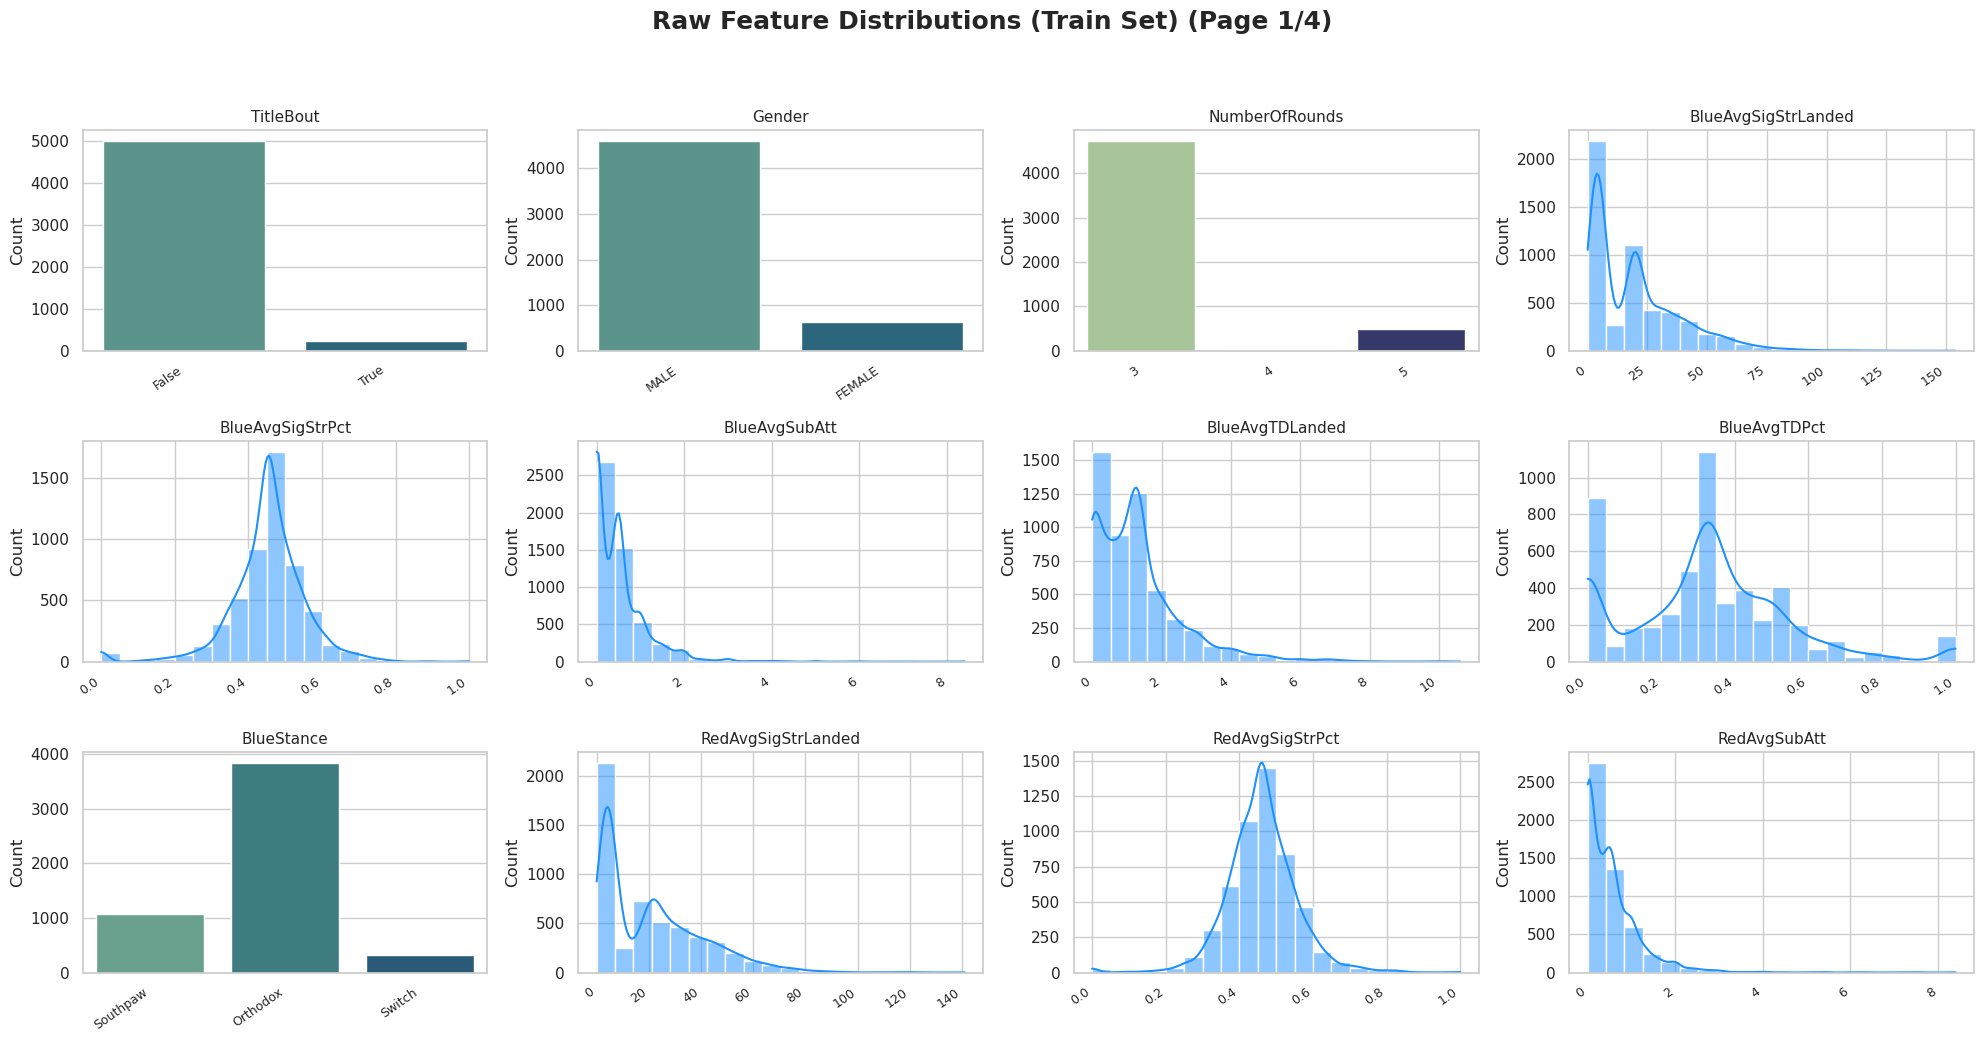

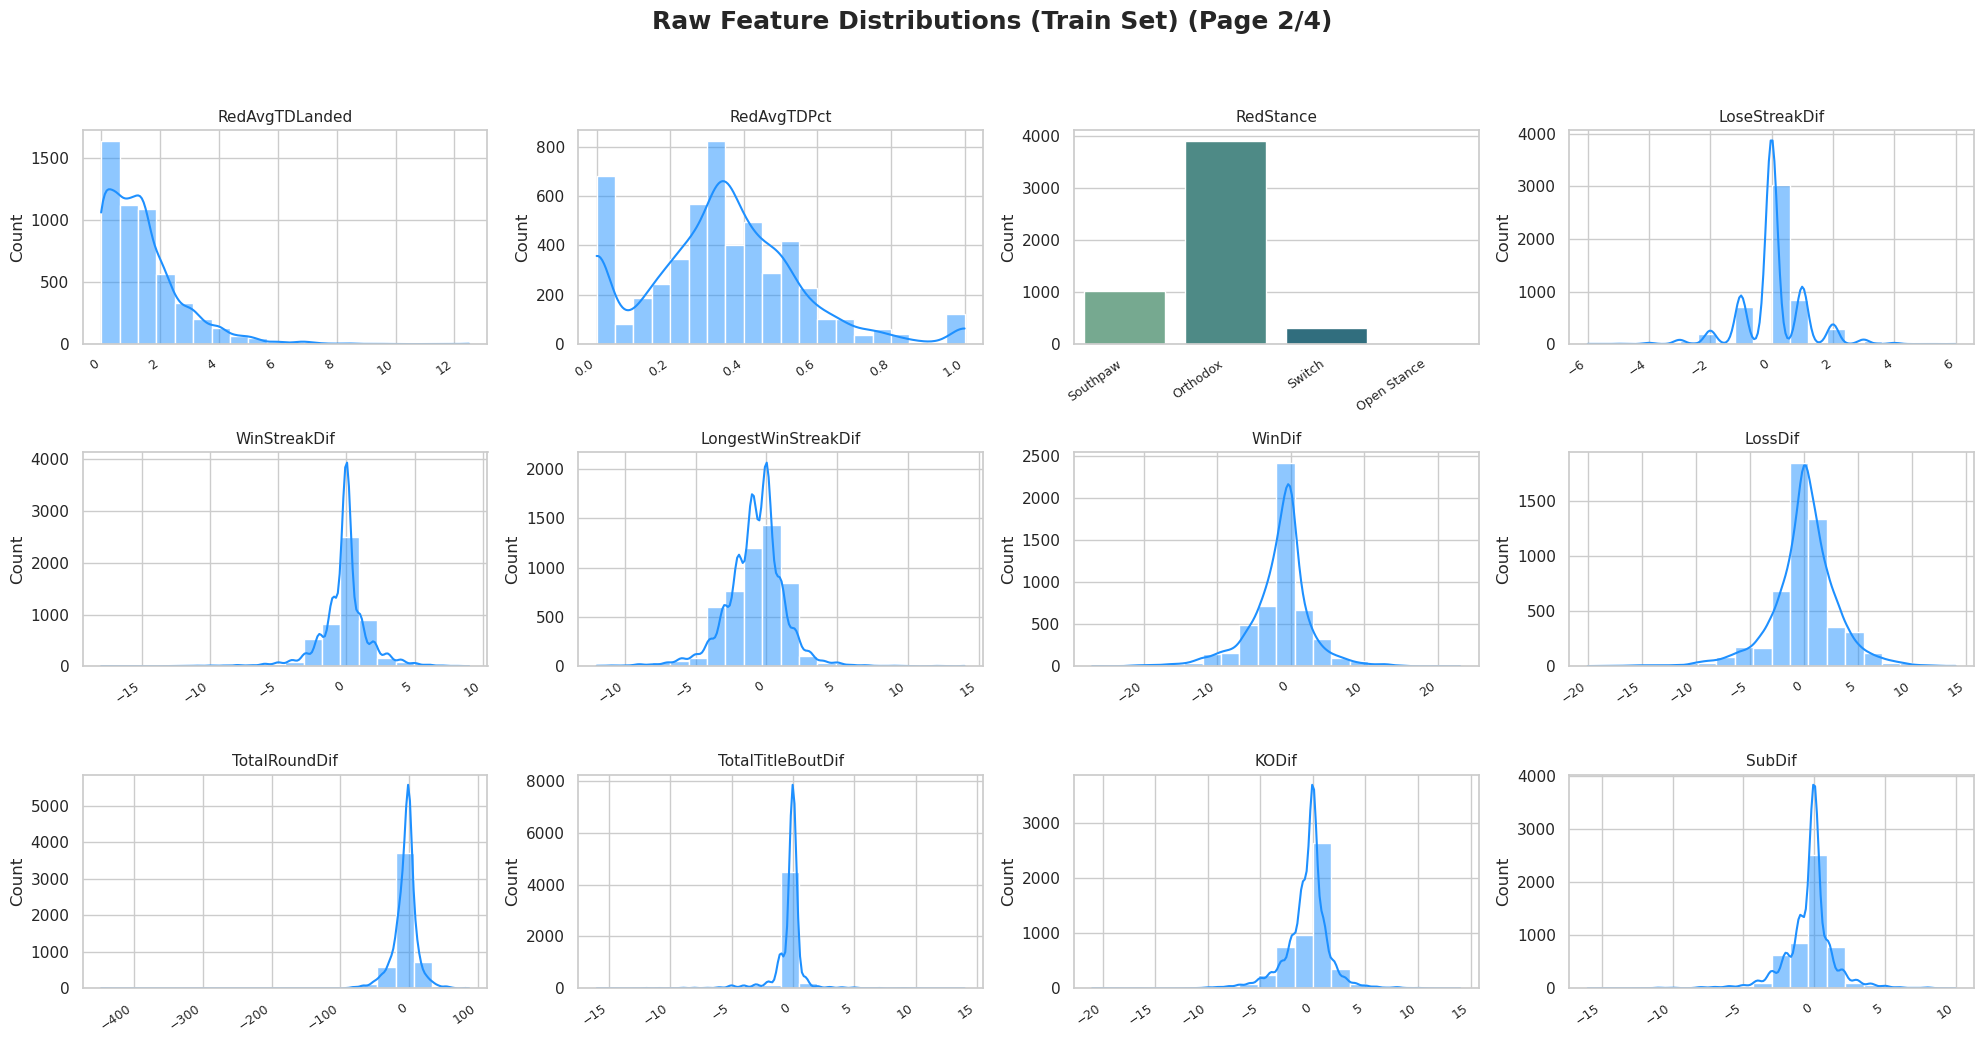

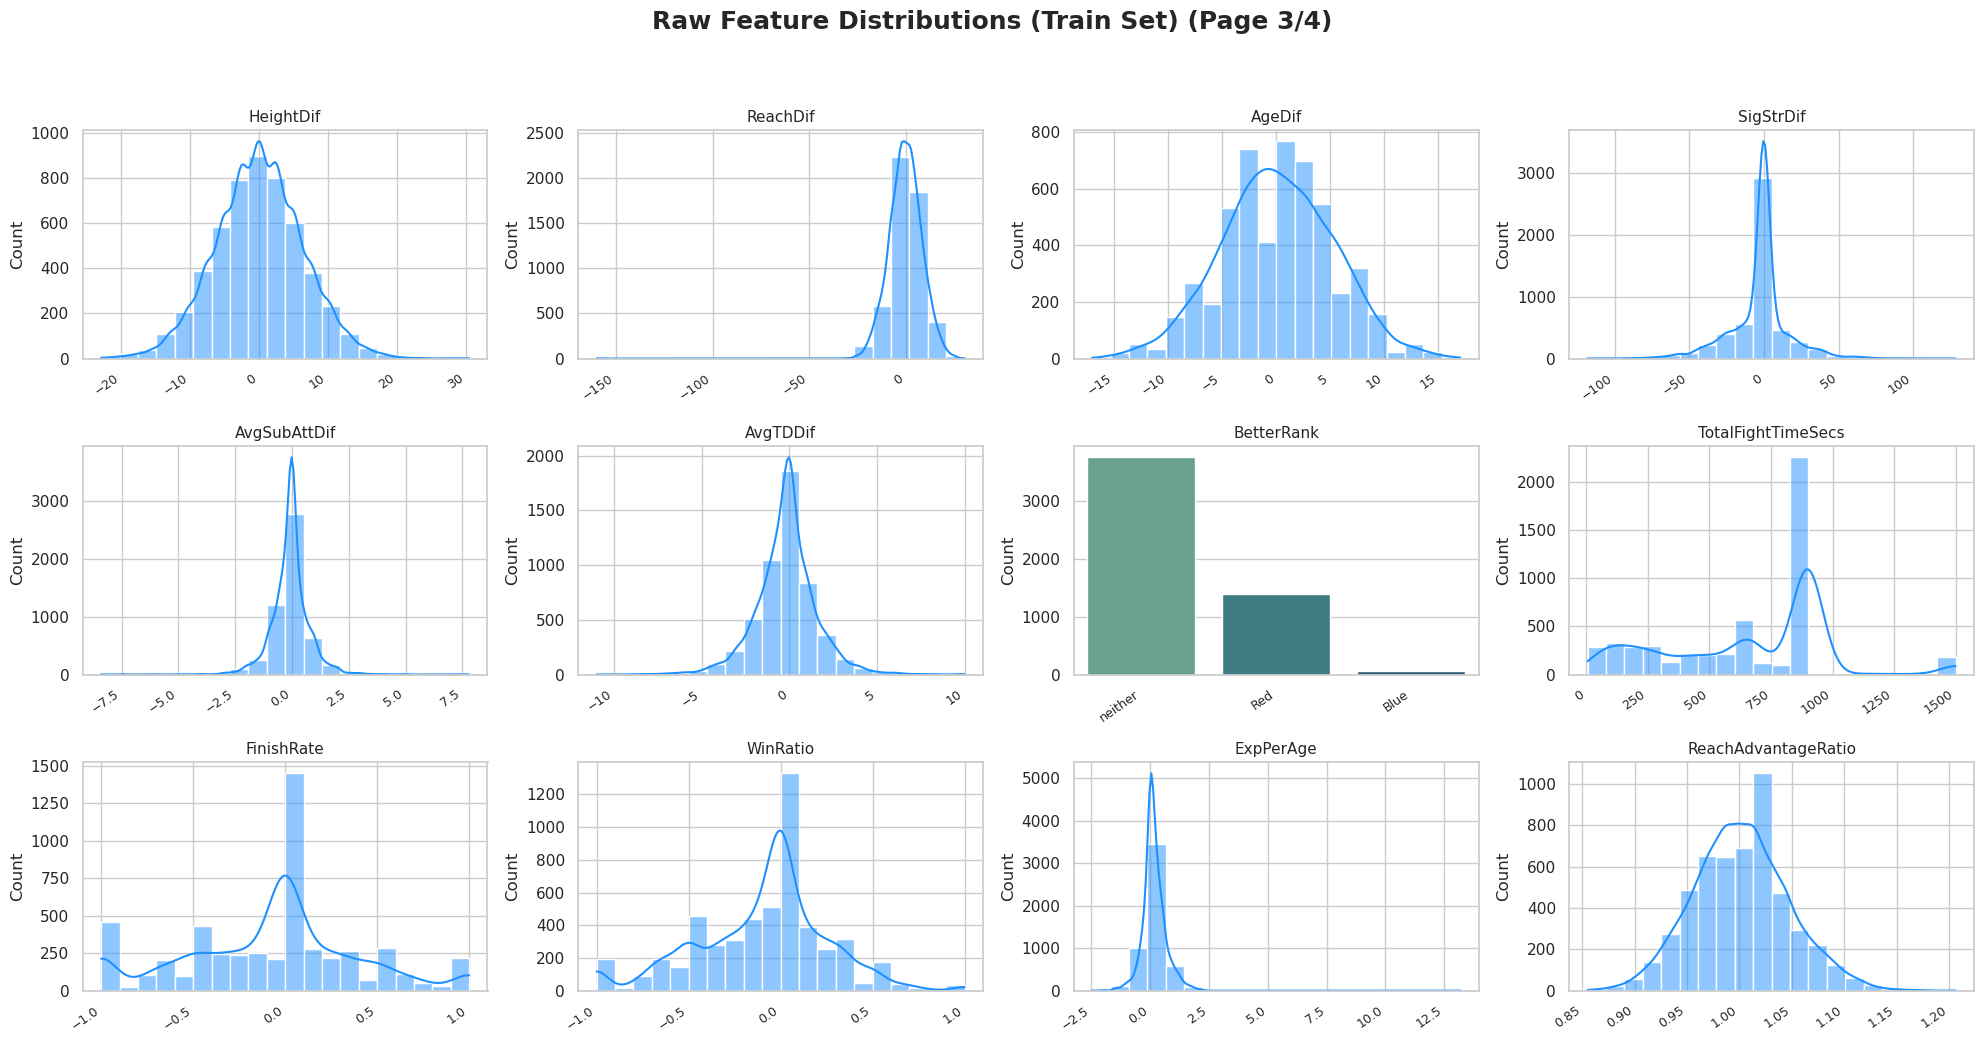

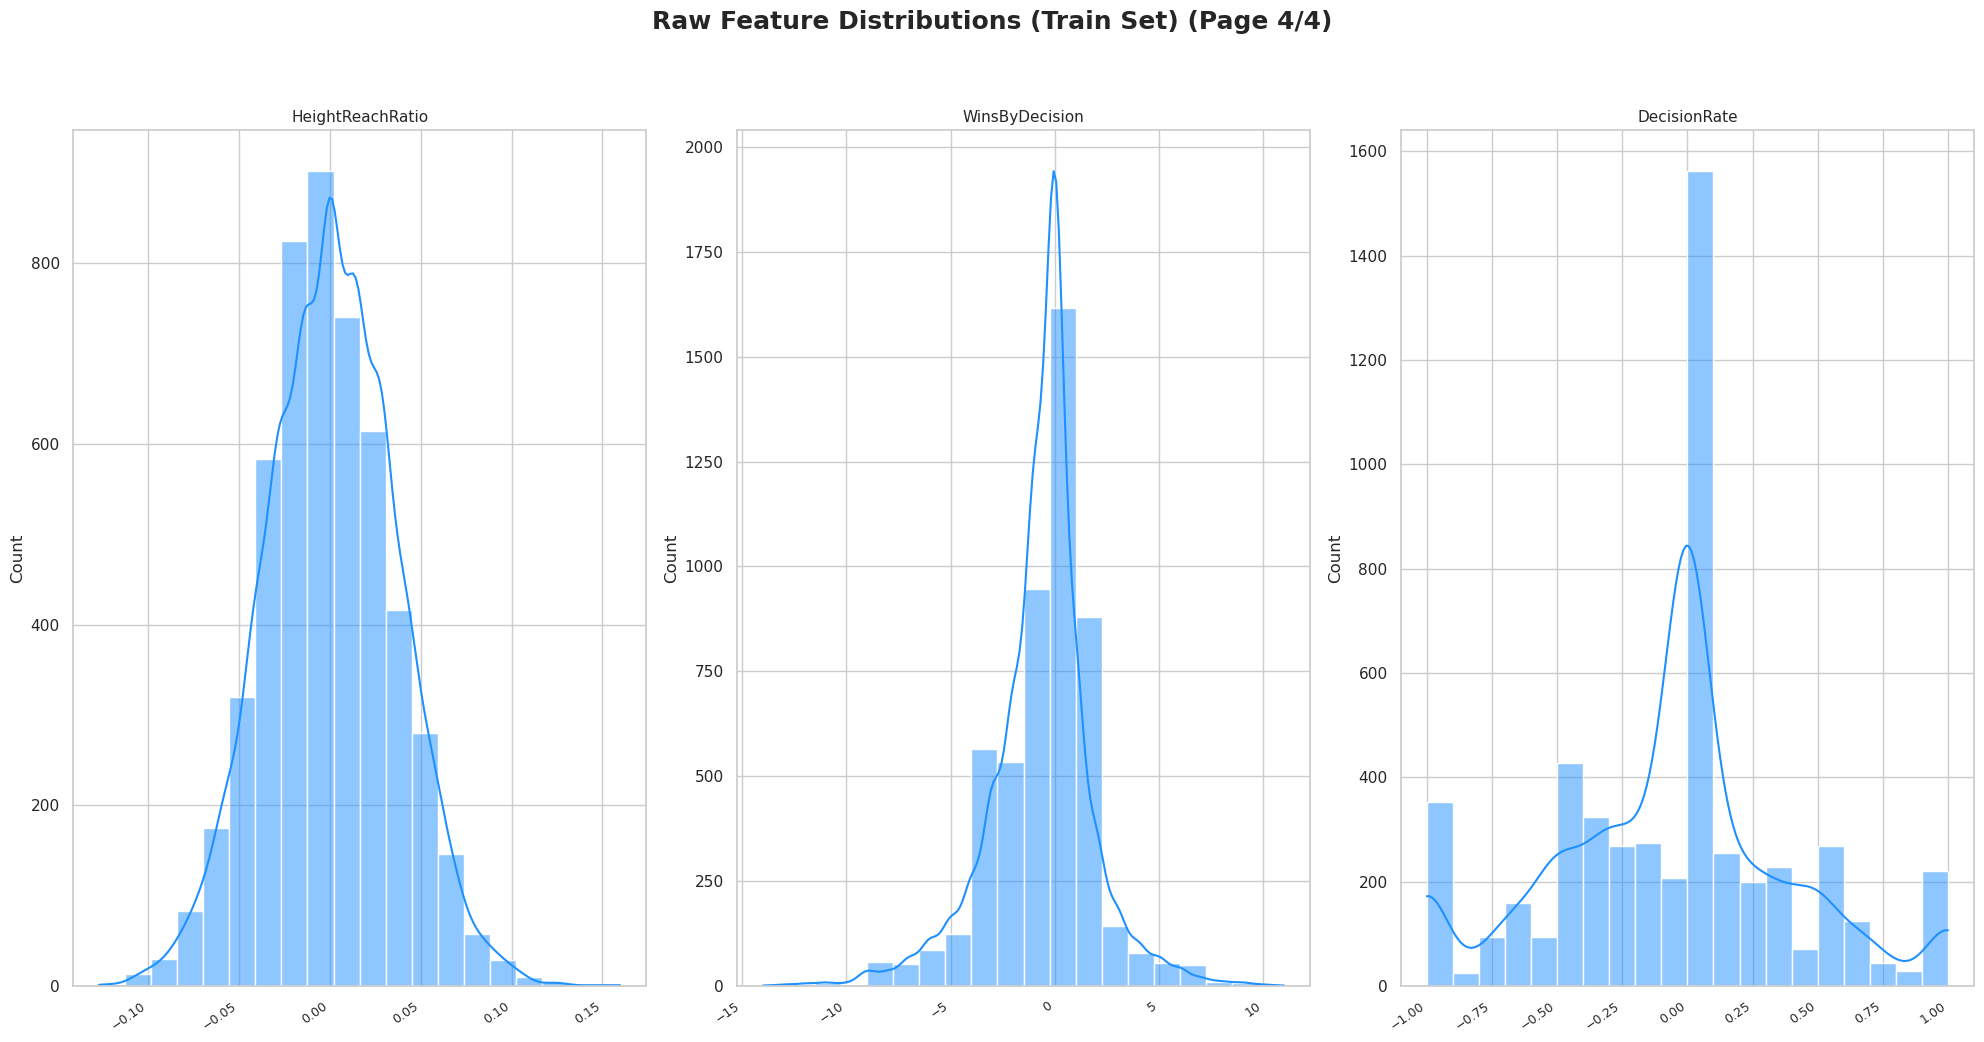

In [26]:
ufc_data.plot_feature_distributions()

<div style="text-align: center;">
  🔹 <img src="../img/ufc_logo.png" width="50" /> 🔹
</div>

## 5. Save

In [27]:
ufc_modeling_data = ufc_data

In [28]:
save_data(ufc_modeling_data)

✅ UFCData object saved to: /home/mfourier/ufc-predictor/data/processed/ufc_data.pkl


In [30]:
save_ufc_datasets(ufc_modeling_data, project_root)

✅ UFCData object saved to: dict_keys(['ufc_train.csv', 'ufc_test.csv', 'ufc_processed_train.csv', 'ufc_processed_test.csv'])


<div style="text-align: center;">
     <img src="../img/ufc_logo.png" width="800" /> 
</div>